In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Loading : images and masks

In [ ]:
def load_dataset(path):
  images=sorted(glob(os.path.join(path,'images','*')))
  masks=sorted(glob(os.path.join(path,'masks','*')))
  return images,masks

Loading dataset

In [ ]:
dataset_path="/content/drive/MyDrive/Dataset/people_segmentation"


In [ ]:
images,masks=load_dataset(dataset_path)
print(f"Images:{len(images)}, Masks:{len(masks)}")

Images:5688, Masks:5688


In [ ]:
for x,y in zip(images,masks):
  print(x,y)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-109669.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks/pexels-photo-109669.png
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-10979.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks/pexels-photo-10979.png
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-109851.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks/pexels-photo-109851.png
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-10988.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks/pexels-photo-10988.png
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-109917.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks/pexels-photo-109917.png
/content/drive/MyDrive/Dataset/people_segmentation/images/pexels-photo-109920.jpg /content/drive/MyDrive/Dataset/people_segmentation/masks

Visualize the dataset

In [ ]:
pip install imshowtools


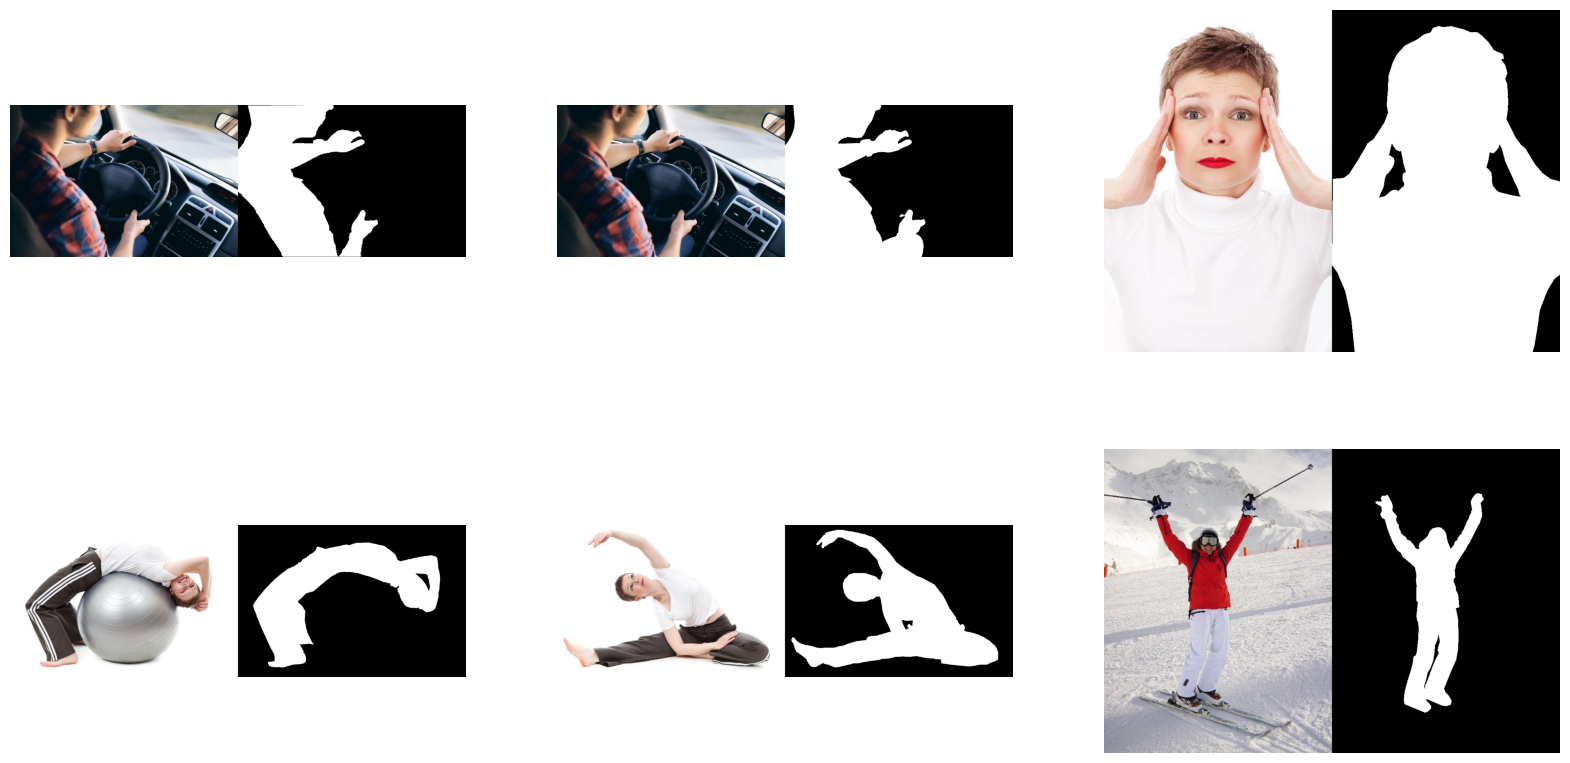

In [ ]:
from imshowtools import imshow

cat=[]
for x,y in zip(images[ :6],masks[ :6]):
  x=cv2.imread(x,cv2.IMREAD_COLOR)
  x=cv2.cvtColor(x,cv2.COLOR_BGR2RGB)
  y=cv2.imread(y,cv2.IMREAD_COLOR)*255
  z=np.concatenate([x,y],axis=1)
  cat.append(z)

imshow(*cat,size=(20,10),columns=3)


Dataset Split

In [ ]:
def split_dataset(images, masks, split=0.1):
  split_value=int(len(images)*split)

  train_x,valid_x=train_test_split(images,test_size=split_value,random_state=42)
  train_y,valid_y=train_test_split(masks,test_size=split_value,random_state=42)

  train_x,test_x=train_test_split(train_x,test_size=split_value,random_state=42)
  train_y,test_y=train_test_split(train_y,test_size=split_value,random_state=42)

  return (train_x,train_y),(valid_x,valid_y),(test_x,test_y)

In [ ]:
(train_x,train_y),(valid_x,valid_y),(test_x,test_y)=split_dataset(images, masks, split=0.1)

In [ ]:
print(f"train_x: {len(train_x)}, train_y: {len(train_y)}\n valid_x: {len(valid_x)}, valid_y: {len(valid_y)} \n test_x: {len(test_x)}, test_y: {len(test_y)} ")

train_x: 4552, train_y: 4552
 valid_x: 568, valid_y: 568 
 test_x: 568, test_y: 568 


Saving the dataset

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
def save_dataset(images, masks, save_path):
    for x, y in tqdm(zip(images, masks), total=len(images)):
        """ Extract the name """
        name = x.split("/")[-1]

        """ Reading the image and mask """
        x = cv2.imread(x, cv2.IMREAD_COLOR)
        y = cv2.imread(y, cv2.IMREAD_COLOR) * 255.0

        """ Saving the image and mask """
        save_image_path = os.path.join(save_path, "images", name)
        save_mask_path = os.path.join(save_path, "masks", name)

        cv2.imwrite(save_image_path, x)
        cv2.imwrite(save_mask_path, y)

In [ ]:
save_dir = "dataset"
for item in ["train", "valid", "test"]:
    create_dir(os.path.join(save_dir, item, "images"))
    create_dir(os.path.join(save_dir, item, "masks"))

In [ ]:

save_dataset(train_x, train_y, os.path.join(save_dir, "train"))

100%|██████████| 4552/4552 [19:48<00:00,  3.83it/s]


In [ ]:
save_dataset(valid_x, valid_y, os.path.join(save_dir, "valid"))

100%|██████████| 568/568 [02:22<00:00,  3.98it/s]


In [ ]:
save_dataset(test_x, test_y, os.path.join(save_dir, "test"))

100%|██████████| 568/568 [02:27<00:00,  3.85it/s]


Training the UNet

Seeding

In [ ]:
import tensorflow as tf

In [ ]:
os.environ['PYTHONHASHSEED']=str(42)
np.random.seed(42)
tf.random.set_seed(42)

Hyperparameters

In [ ]:
batch_size=4
lr=1e-4 #0.0001
epochs=100
height=512
width=512

# **IMPLEMENTING ATTENTION MECHANISM**

CBAM - Convulutional Block Attention Module

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Conv2D,BatchNormalization,Activation, MaxPool2D,Conv2DTranspose,Concatenate,Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D,Reshape,Dense,Multiply

Channel attention Module

In [ ]:
def channel_attention_module(x,ratio=8):
  channel=x.shape[-1]

  l1=Dense(channel//ratio,activation="relu",use_bias=False)
  l2=Dense(channel,use_bias=False)

  x1=GlobalAveragePooling2D()(x)
  x1=l1(x1)
  x1=l2(x1)

  x2=GlobalAveragePooling2D()(x)
  x2=l1(x2)
  x2=l2(x2)

  feats=x1+x2
  feats=Activation("sigmoid")(feats)

  feats=Multiply()([x,feats])
  return feats



In [ ]:
x=Input((128,128,64))
y=channel_attention_module(x)
print(y.shape)


Spatial Attention Module

In [ ]:
def spatial_attention_module(x):
  x1=tf.reduce_mean(x,axis=-1)
  x1=tf.expand_dims(x1,axis=-1)

  x2=tf.reduce_mean(x,axis=-1)
  x2=tf.expand_dims(x2,axis=-1)

  feats=Concatenate()([x1,x2])
  feats=Conv2D(1,kernel_size=7,padding="same",activation="sigmoid")(feats)

  feats=Multiply()([x,feats])
  return feats



In [ ]:
x=Input((128,128,64))
y=spatial_attention_module(x)
print(y.shape)

Convolutional Block Attention Module

In [ ]:
def cbam(x):
  x=channel_attention_module(x)
  x=spatial_attention_module(x)
  return x



In [ ]:
x=Input((128,128,64))
y=cbam(x)
print(y.shape)

Building UNET

In [ ]:
def conv_block(inputs,num_filters):
  x=Conv2D(num_filters,3,padding="same")(inputs)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=Conv2D(num_filters,3,padding="same")(x)
  x=BatchNormalization()(x)
  x=Activation("relu")(x)

  x=cbam(x)

  return x

Decoder Block

In [ ]:
def decoder_block(inputs,skip,num_filters):
  x=Conv2DTranspose(num_filters,(2,2),strides=2,padding="same")(inputs)
  x=Concatenate()([x,skip])
  x=conv_block(x,num_filters)
  return x


UNET

In [ ]:
def build_unet(input_shape):
    """ Inputs """
    inputs = Input(input_shape)

    """ ResNet50 Encoder """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)

    s1 = resnet50.get_layer("input_5").output
    s2 = resnet50.get_layer("conv1_relu").output
    s3 = resnet50.get_layer("conv2_block3_out").output
    s4 = resnet50.get_layer("conv3_block4_out").output

    b1 = resnet50.get_layer("conv4_block6_out").output

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

### **TRAINING THE Model using DATASET**

Path

In [ ]:
dataset_pathh="/content/drive/MyDrive/Dataset/people_segmentation"

In [ ]:
dataset_path="/content/dataset"

files_dir=os.path.join(dataset_pathh,'files')
model_file=os.path.join(files_dir,"unet.h5")
log_file=os.path.join(files_dir,"log.csv")

In [ ]:
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
create_dir(files_dir)

# **Dataset Pipeline**

Loading Training and Validation dataset

In [ ]:
def loa
d_data(path):
  train_x=sorted(glob(os.path.join(path,"train","images","*")))
  train_y=sorted(glob(os.path.join(path,"train","masks","*")))

  valid_x=sorted(glob(os.path.join(path,"valid","images","*")))
  valid_y=sorted(glob(os.path.join(path,"valid","masks","*")))

  return (train_x,train_y),(valid_x,valid_y)

Reading Images

In [ ]:
def read_image(path):
  path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_COLOR)
  x = cv2.resize(x, (width, height))
  x=x/255.0
  return x

Reading Masks

In [ ]:
def read_mask(path):
  path=path.decode()
  x=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  x = cv2.resize(x, (width, height))
  x=x/255.0
  x=np.expand_dims(x,axis=-1)
  return x

tf.data pipeline

In [ ]:
def tf_parse(x,y):
  def _parse(x,y):
    x=read_image(x)
    y=read_mask(y)
    return x,y

  x,y=tf.numpy_function(_parse,[x,y],[tf.float64,tf.float64])
  x.set_shape([height,width,3])
  y.set_shape([height,width,1])

  return x,y

In [ ]:
def tf_dataset(x,y,batch=8):
  dataset=tf.data.Dataset.from_tensor_slices((x,y))
  dataset=dataset.map(tf_parse,num_parallel_calls=tf.data.AUTOTUNE)
  dataset=dataset.batch(batch)
  dataset=dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

Training

In [ ]:
(train_x,train_y),(valid_x,valid_y)=load_data(dataset_path)
print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Valid: {len(valid_x)} - {len(valid_y)}")

Train: 4552 - 4552
Valid: 568 - 568


In [ ]:
train_dataset=tf_dataset(train_x,train_y,batch=batch_size)
valid_dataset=tf_dataset(valid_x,valid_y,batch=batch_size)

In [ ]:
for x, y in train_dataset:
  print(x.shape,y.shape)

  break

(4, 512, 512, 3) (4, 512, 512, 1)


Run the Model

In [ ]:
input_shape=(height,width,3)
model=build_unet(input_shape)

In [ ]:
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 518, 518, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 256, 256, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 256, 256, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                           

Loss Function

In [ ]:
def dice_loss(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2. * intersection + 1e-15) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-15)
    return 1.0 - dice

In [ ]:
opt=tf.keras.optimizers.Adam(lr)
model.compile(loss=dice_loss,optimizer=opt,metrics=["acc"])

In [ ]:
callbacks=[
    ModelCheckpoint(model_file,verbose=1,save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=4),
    CSVLogger(log_file),
    EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=False)

]

In [ ]:
model.fit(train_dataset,validation_data=valid_dataset,epochs=epochs,callbacks=callbacks)

Epoch 1/100
1138/1138 [==============================] - ETA: 0s - loss: 0.3518 - acc: 0.8247
Epoch 1: val_loss improved from inf to 0.27676, saving model to /content/drive/MyDrive/Dataset/people_segmentation/files/unet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1138/1138 [==============================] - 1125s 929ms/step - loss: 0.3518 - acc: 0.8247 - val_loss: 0.2768 - val_acc: 0.8702 - lr: 1.0000e-04
Epoch 2/100
1138/1138 [==============================] - ETA: 0s - loss: 0.2146 - acc: 0.8748
Epoch 2: val_loss improved from 0.27676 to 0.22572, saving model to /content/drive/MyDrive/Dataset/people_segmentation/files/unet.h5
1138/1138 [==============================] - 1099s 966ms/step - loss: 0.2146 - acc: 0.8748 - val_loss: 0.2257 - val_acc: 0.8765 - lr: 1.0000e-04
Epoch 3/100
1138/1138 [==============================] - ETA: 0s - loss: 0.1810 - acc: 0.8887
Epoch 3: val_loss improved from 0.22572 to 0.20179, saving model to /content/drive/MyDrive/Dataset/people_segmentation/files/unet.h5
1138/1138 [==============================] - 1058s 930ms/step - loss: 0.1810 - acc: 0.8887 - val_loss: 0.2018 - val_acc: 0.8898 - lr: 1.0000e-04
Epoch 4/100
1138/1138 [==============================] - ETA: 0s - loss: 0.1622 - acc: 0.8980
Epoch 4: val_loss